# Part 1: Q-Learning: sophisticated types of action selection

**Q-Learning** is arguably one of the most influential ways of combining insights from learning and **trial and error** on the one hand as well as **optimal control theory** on the other. You will see that the theory is based on a subtle twist of the TD algorithm.

This will only be a brief introduction to Q-Learning, but we will come back to this later.

The structure of the code is inspired by Sutton and Barto, Chapter 6.5 and based on the Q-learning tutorial from Neuromatch 2020 (https://academy.neuromatch.io/nma2020/course-materials).

We start with the usual imports and defining some helper functions.

In [1]:
# Imports
import numpy as np                 
import matplotlib.pyplot as plt

In [2]:
# @title Helper functions
from scipy.signal import convolve as conv

def epsilon_greedy(q, epsilon):

  """Epsilon-greedy policy: selects maximum value action with probabilty
  (1-epsilon) and selects randomly with epsilon probability.
    
  Input:
  q: an array of action values
  epsilon: probability of selecting an action randomly 
  
  Returns:
  action: chosen action
  """

  if np.random.random() > epsilon:
    action = np.argmax(q)
  else:
    action = np.random.choice(len(q)) 

  return action

def get_outcome(state, action):
  
  """
  Function to produce one transition in the grid world based on known rules.

  Explanation:

  World: Cliff world.
  
  40 states (4-by-10 grid world).
  The mapping from state to the grids are as follows:
  30 31 32 ... 39
  20 21 22 ... 29
  10 11 12 ... 19
  0  1  2  ...  9

  0 is the starting state (S) and 9 is the goal state (G).

  Actions 0, 1, 2, 3 correspond to right, up, left, down.
  
  Moving anywhere from state 9 (goal state) will end the session.
  
  Taking action down at state 11-18 will go back to state 0 and incur a reward of -100.
  
  Landing in any states other than the goal state will incur a reward of -1.
  
  Going towards the border when already at the border will stay in the same place.
  """

  if state == 9:  # goal state
    reward = 0
    next_state = None
    return next_state, reward

  reward = -1  # default reward value

  if action == 0:  # move right
    next_state = state + 1
    if state % 10 == 9:  # right border
      next_state = state
    elif state == 0:  # start state (next state is cliff)
      next_state = None
      reward = -100
  elif action == 1:  # move up
    next_state = state + 10
    if state >= 30:  # top border
      next_state = state
  elif action == 2:  # move left
    next_state = state - 1
    if state % 10 == 0:  # left border
      next_state = state
  elif action == 3:  # move down
    next_state = state - 10
    if state >= 11 and state <= 18:  # next is cliff
      next_state = None
      reward = -100
    elif state <= 9:  # bottom border
      next_state = state
  else:
    print("Action must be between 0 and 3.")
    next_state = None
    reward = None
    
  return int(next_state) if next_state is not None else None, reward

def learn_environment(learning_rule, params, max_steps, n_episodes, n_states = 40, n_actions = 4, init_state = 0): 
  
  # Start with a uniform value function
  value = np.ones((n_states, n_actions))

  # Run learning
  reward_sums = np.zeros(n_episodes)

  # Loop over episodes
  for episode in range(n_episodes):

    state = init_state  # initialize state   

    reward_sum = 0

    for t in range(max_steps):
      # choose next action
      action = epsilon_greedy(value[state], params['epsilon'])
      
      # observe outcome of action on environment
      next_state, reward = get_outcome(state, action)

      # update value function
      value = learning_rule(state, action, reward, next_state, value, params)
      
      # sum rewards obtained
      reward_sum += reward
      
      if next_state is None:
          break  # episode ends
      state = next_state      
      
      reward_sums[episode] = reward_sum
  
  return value, reward_sums


def plot_state_action_values(value, n_states = 40, n_actions = 4):
  
  """
  Generate plot showing value of each action at each state.
  """

  for a in range(n_actions): 
    plt.plot(range(n_states), value[:, a], marker='o', linestyle='--')
  plt.xlabel('States')
  plt.ylabel('Values')
  plt.legend(['Right','Up','Left','Down'], loc='lower right')
  

def plot_quiver_max_action(value, title_plot=None, dim_x = 10, dim_y = 4):
  
  """
  Generate plot showing action of maximum value or maximum probability at
    each state.
  """

  X = np.tile(np.arange(dim_x), [dim_y,1]) + 0.5
  Y = np.tile(np.arange(dim_y)[::-1][:,np.newaxis], [1,dim_x]) + 0.5
  which_max = np.reshape(value.argmax(axis=1), (dim_y,dim_x))
  which_max = which_max[::-1,:]
  U = np.zeros(X.shape)
  V = np.zeros(X.shape)
  U[which_max == 0] = 1
  V[which_max == 1] = 1
  U[which_max == 2] = -1
  V[which_max == 3] = -1

  # leave out action predictions at the cliff
  X[3] = X[3][0]
  Y[3] = Y[3][0]
  U[3] = U[3][0]
  V[3] = V[3][0]

  plt.quiver(X, Y, U, V)
  if title_plot is None:
    plt.title('Maximum value/probability actions')
  else:
    plt.title(title_plot)
  plt.xlim([-0.5, dim_x+0.5])
  plt.ylim([-0.5, dim_y+0.5])
 
  plt.xticks(np.arange(dim_x+1),labels=[])
  plt.grid()
  plt.text(0.2, 0.3, 'Start',fontsize=10)
  plt.text(9.2, 0.3, 'Goal',fontsize=10)
  plt.text(1.2, 0.3, 'Cliff',fontsize=10)
  plt.text(2.2, 0.3, 'Cliff',fontsize=10)
  plt.text(3.2, 0.3, 'Cliff',fontsize=10)
  plt.text(4.2, 0.3, 'Cliff',fontsize=10)
  plt.text(5.2, 0.3, 'Cliff',fontsize=10)
  plt.text(6.2, 0.3, 'Cliff',fontsize=10)
  plt.text(7.2, 0.3, 'Cliff',fontsize=10)
  plt.text(8.2, 0.3, 'Cliff',fontsize=10)

  plt.yticks(np.arange(dim_y+1),labels=[])

def plot_heatmap_max_val(value, dim_x = 10, dim_y = 4, name = "cliff_world"):
  
  """
  Generate heatmap showing maximum value at each state
  """

  if value.ndim == 1:
      value_max = np.reshape(value, (dim_y,dim_x))
  else:
      value_max = np.reshape(value.max(axis=1), (dim_y,dim_x))      
  value_max = value_max[::-1,:]

  im = plt.imshow(value_max, aspect='auto', interpolation='none', cmap='afmhot')
  plt.title('Maximum value per state')
  plt.xticks(np.linspace(0, dim_x-1, num=dim_x),labels=["%d" % x for x in np.arange(dim_x)])
  plt.yticks(np.linspace(0, dim_y-1, num=dim_y),labels=["%d" % y for y in np.arange(0, dim_y*dim_x, dim_x)][::-1])

  return im


def plot_rewards(n_episodes, rewards, average_range=10):
  
  """
  Generate plot showing total reward accumulated in each episode.
  """

  smoothed_rewards = (conv(rewards, np.ones(average_range), mode='same')
                      / average_range)
  
  plt.plot(range(0, n_episodes, average_range),
          smoothed_rewards[0:n_episodes:average_range],
          marker='o', linestyle='--')
  
  plt.xlabel('Episodes')
  plt.ylabel('Total reward')

def plot_performance(value, reward_sums):
  plt.rcParams['figure.figsize'] = [16, 12]
  rows = 2
  cols = 2
  fig = plt.figure() 

  fig_count = 1
  fig.add_subplot(rows, cols, fig_count)
  plot_state_action_values(value)

  fig_count = 2
  fig.add_subplot(rows, cols, fig_count)
  plot_quiver_max_action(value)

  fig_count = 3
  fig.add_subplot(rows, cols, fig_count)
  plot_rewards(n_episodes, reward_sums)

  fig_count = 4
  fig.add_subplot(rows, cols, fig_count)
  im = plot_heatmap_max_val(value)
  fig.colorbar(im)

  plt.show()

---
## More complicated environments: Cliff-World

A crucial bit is missing in the multi-armed bandit case: your current actions do not influence what actions you can take in the future, or what states are available some time later.

This is very different from real-world situations. Take navigation for example: moving into a certain direction will constrain the possible actions you can take in the future.

A gold standard paradigm to study such problems is called 'cliff-world', which looks like this:

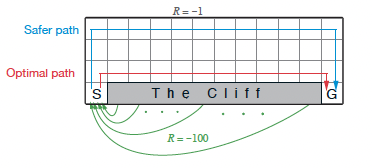

"This is a standard undiscounted, episodic task, with start and goal states, and the usual actions causing movement up, down, right, and left. Reward is −1 on all transitions except those into the region marked “The Cliff.” Stepping into this region incurs a reward of −100 and sends the agent instantly back to the start." (Sutton & Barto, p132)

So the key problem an agent has to solve is to move from a 'Start' position to a 'Goal' location. It must avoid falling off the cliff. 

There are different paths the agent can take. Do you have an idea which aspect of the task design compels agents to find the shortest possible path?

## Q-Learning

One of the most influential algorithms to solve such tasks is called **Q-learning**, which takes the form:

\begin{align}
Q(s_t,a_t) \leftarrow Q(s_t,a_t) + \alpha \big(r_t + \gamma\max_\limits{a} Q(s_{t+1},a_{t+1}) - Q(s_t,a_t)\big)
\end{align}

Note that we are not estimating the value of a state $V(s_t)$ any more, but the value of a specific action $a_t$ in a specific state $s_t$, which we write as $Q(s_t,a_t)$. Importantly, this allows agents to find the best action for a given state. You can think of this as an extension of TD-learning into operant conditioning problems.

In [3]:
# @title Exercise 1.1: Understanding the algorithm

Can you guess what the algorithm is doing? How is it comparable to TD-learning, how does it differ? What does the max operation do you think?

In [4]:
# @title Exercise 1.2: Implement Q-Learning

Define a function called q_learning, which implements the above algorithm. Hint: this will look very similar to the update_action_value() function in the previous Action Selection Tutorial, except that is has to follow the specifics of the above equation.

This algorithm requires quite a lot of input, namely:
- **state**: and index of the current state (i.e. a number between 0 and $N_{states}$)
- **action**: the action taken at a given trial (i.e. a number between 0 and $N_{actions}$)
- **reward**: The received reward at a given trial
- **next_state**: the index of the next state (i.e. a number between 0 and $N_{states}$)
- **value**: this is a matrix consisting of $states$ x $actions$. You will need this matrix to find the maximum value over actions for the next state (defined via next_state).
- The required **parameters**.

The function should return an **updated value** term, where the Q-value for the current state-action pair has been updated.

You can start with finding the max Q-value for the next state, and then implement the update equation above. Note: you should also implement a case (via an if-statement) for the next_state being 'None', which happens when there is no next state (e.g. at the end of an experiment).

Take some time to think about the implementation - and then it's a good idea to use the 'Partial' or 'Full' Solution and see if you can make sense of what's going on :)

In [5]:
# Your code goes here..

In [6]:
# @title Partial Solution

def q_learning(state, action, reward, next_state, value, alpha, gamma):
  
  """
  Q-learning: updates the value function and returns it.
  
  Input:
    state:  current state identifier
    action: action taken
    reward: reward received
    next_state: transitioned to state identifier
    value: current value function of shape (n_states, n_actions)
    params: a dictionary containing the default parameters
 
  Returns:
    value: the updated value function of shape (n_states, n_actions)
  """

  # Find the Q-value of current state-action pair
  # uncomment below:
  # q = ...

  # find maximum Q-value at the current state
  # uncomment below:
  # if next_state is None:
  #   max_next_q = 0
  # else:
    # max_next_q = np.max(...)

  # write the expression to compute the (TD type) error based on q and max_next_q
  # uncomment below:
  # td_error = reward + params['gamma'] * ...

  # write the expression that updates the Q-value for the state-action pair  
  value = 0
  # uncomment below:
  # value[state, action] = q + params['alpha'] * ...
  
  return value

In [7]:
# @title Full Solution

def q_learning(state, action, reward, next_state, value, params):
  
  """
  Q-learning: updates the value function and returns it.
  
  Input:
    state:  current state identifier
    action: action taken
    reward: reward received
    next_state: transitioned to state identifier
    value: current value function of shape (n_states, n_actions)
    params: a dictionary containing the default parameters
 
  Returns:
    value: the updated value function of shape (n_states, n_actions)
  """

  # Q-value of current state-action pair
  q = value[state, action]

  # find maximum Q-value at the current state
  if next_state is None:
    max_next_q = 0
  else:
    max_next_q = np.max(value[next_state,:])

  # write the expression to compute the (TD type) error
  td_error = reward + params['gamma'] * max_next_q - q

  # write the expression that updates the Q-value for the state-action pair  
  value[state, action] = q + params['alpha'] * td_error
  
  return value

## Test Performance

We can now see how Q-learning performs in the above cliff-world environment. This is based on helper functions defined above - you can take a look at them if you want to, but some of them are a bit dense, so don't worry too much about them.

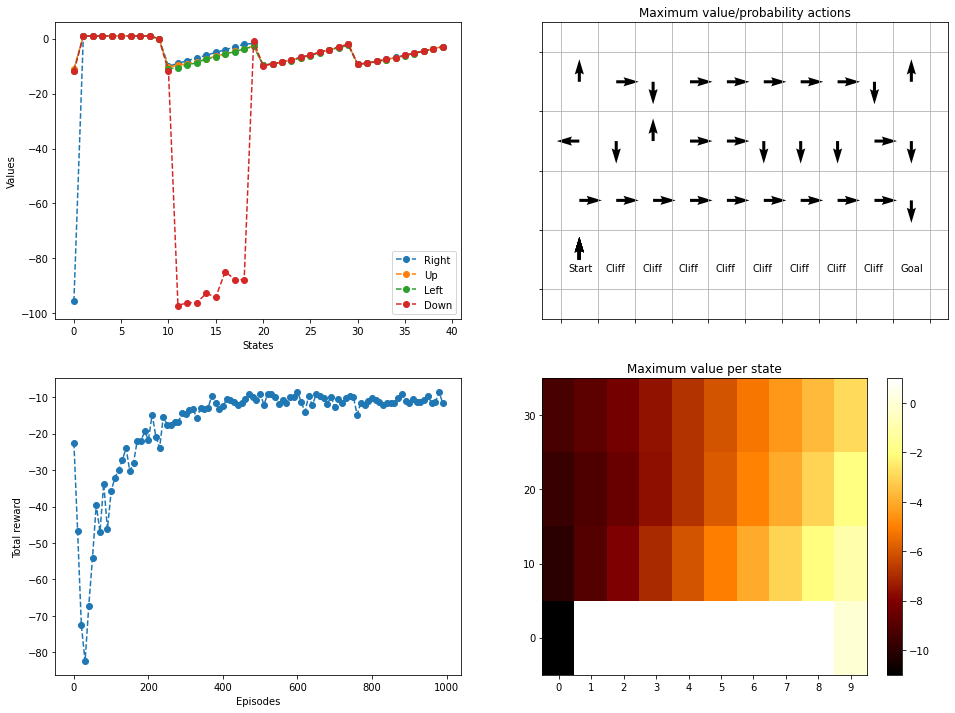

In [8]:
# set for reproducibility, comment out / change seed value for different results
np.random.seed(1)

# parameters needed by our policy and learning rule
params = {
  'epsilon': 0.1,  # epsilon-greedy policy
  'alpha': 0.1,  # learning rate    
  'gamma': 1.0,  # discount factor
}

# episodes/trials
n_episodes = 1000
max_steps = 1000

# solve Cliff World using Q-learning
results = learn_environment(q_learning, params, max_steps, n_episodes)
value_qlearning, reward_sums_qlearning = results

# Plot results
plot_performance(value_qlearning, reward_sums_qlearning)

In [9]:
# @title Exercise 1.3: Understanding the algorithm part II

Can you make sense of the plots above?

In [10]:
# @title Exercise 1.4: Importance of looking ahead

Similar as TD-Learning, Q-Learning rests on the idea that we learn based on the current reward and our value estimate for the future. This critically enables backpropagation of reward knowledge through time.

Can you simulate what happens if this look-ahead is missing? You can either change the relevant line of code above or copy and paste the above code and define a simple (non-)Q-Learner that doesn't look ahead. What is the resulting behaviour?

# (Bonus) Part 2: SARSA: an alternative to Q-learning

Q-Learning is called an **off-policy method**. This is because we are only interested in the $max$ over next values, not necessarily the next values that we are *likely* to take.

There is an alternative on-ploicy method called **SARSA** (because we are updating based on **S**tate-**A**ction-**R**eward-**S**tate-**A**ction sequences)

SARSA value updates are defined as 

\begin{align}
Q(s_t,a_t) \leftarrow Q(s_t,a_t) + \alpha \big(r_t + \gamma Q(s_{t+1},a_{t+1}) - Q(s_t,a_t)\big)
\end{align}

As you can see, the only difference is that we have lost the $max$ operation, and now take the value estimate of the next state-action pair based on the current policy.

In [11]:
def sarsa(state, action, reward, next_state, value, params):
  
  """
  SARSA: updates the value function and returns it.
  
  Input:
    state: the current state identifier
    action: the action taken
    reward: the reward received
    next_state: the transitioned to state identifier
    value: current value function of shape (n_states, n_actions)
    params: a dictionary containing the default parameters
 
  Returns:
    value: the updated value function of shape (n_states, n_actions)
  """

  # value of previous state-action pair
  q = value[state, action]

  # select the expected value at current state based on our policy by sampling from it
  if next_state is None:
    policy_next_q = 0
  else:
    # Select a next action using epsilon-greedy:
    policy_action = epsilon_greedy(value[next_state], params['epsilon'])

    # Obtaining the value of the policy action at the current state
    policy_next_q = value[next_state, policy_action]
  
  # Compute the TD error
  td_error = reward + params['gamma'] * policy_next_q - q  

  # Update the Q-value for the state-action pair  
  value[state, action] = q + params['alpha'] * td_error
  
  return value

## Test Performance

Now let's see how SARSA performs in the cliff-world example:

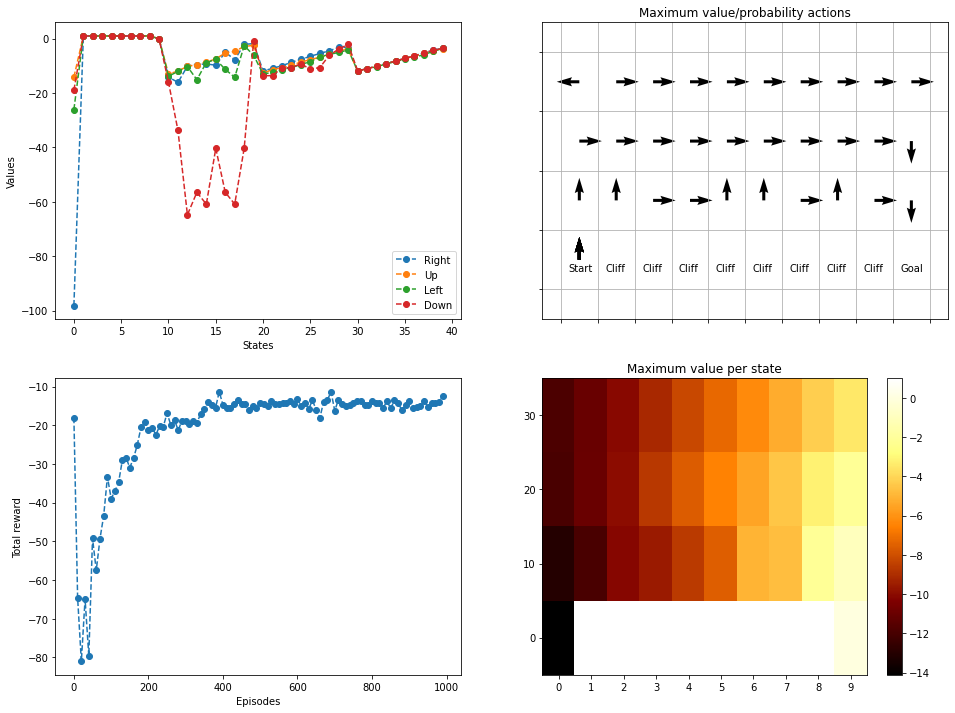

In [12]:
# set for reproducibility, comment out / change seed value for different results
np.random.seed(1)

# parameters needed by our policy and learning rule
params = {
  'epsilon': 0.1,  # epsilon-greedy policy
  'alpha': 0.1,  # learning rate    
  'gamma': 1.0,  # discount factor
}

# episodes/trials
n_episodes = 1000
max_steps = 1000

# learn Cliff World using Sarsa
results = learn_environment(sarsa, params, max_steps, n_episodes)
value_sarsa, reward_sums_sarsa = results

# Plot results
plot_performance(value_sarsa, reward_sums_sarsa)

In [13]:
# @title (Bonus) Exercise 2.1: Understanding SARSA

The differences to Q-Learning in this task are very subtle. Can you spot some nevertheless?

Hint: The values for moving 'down' when the cliff is underneath the agent are a bit different (less negative). Do you have an idea why that might be the case? Hint: this relates to differences in behaviour that cause the agent to sample different states more/less often.

# (Bonus) Part 3: Compare Off-Ploicy and On-Policy

Now let's see how the performance of the two agents compares:

In [14]:
# parameters needed by our policy and learning rule
params = {
  'epsilon': 0.1,  # epsilon-greedy policy
  'alpha': 0.1,  # learning rate    
  'gamma': 1.0,  # discount factor
}

# episodes/trials
n_episodes = 1000
max_steps = 1000

# learn Cliff World using Sarsa
np.random.seed(1)
results = learn_environment(q_learning, params, max_steps, n_episodes)
value_qlearning, reward_sums_qlearning = results

np.random.seed(1)
results = learn_environment(sarsa, params, max_steps, n_episodes)
value_sarsa, reward_sums_sarsa = results

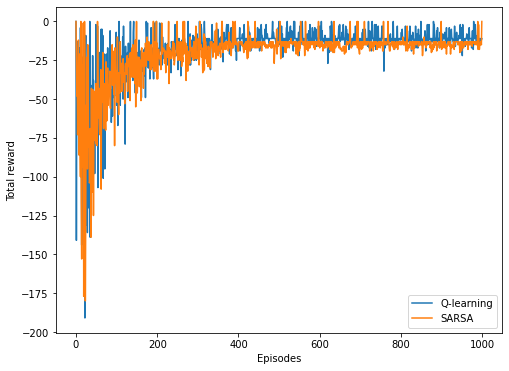

In [15]:
plt.rcParams['figure.figsize'] = [8, 6]
plt.plot(reward_sums_qlearning, label='Q-learning')
plt.plot(reward_sums_sarsa, label='SARSA')
plt.xlabel('Episodes')
plt.ylabel('Total reward')
plt.legend()
plt.show()

The performance differences aren't super striking. But the learned actions look different:

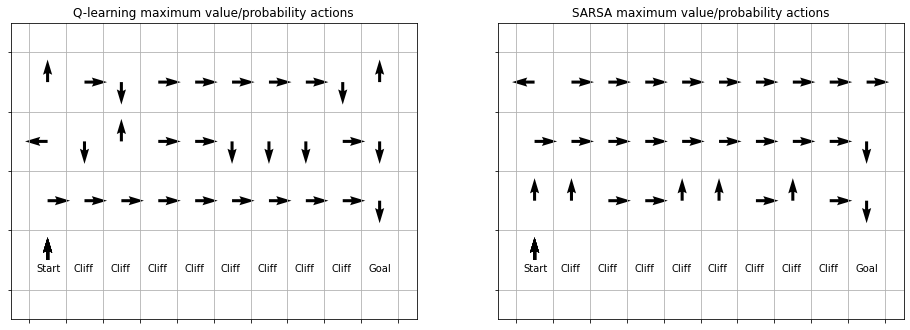

In [16]:
plt.rcParams['figure.figsize'] = [16, 12]
rows,cols = 2,2
fig = plt.figure() 

fig_count = 1
fig.add_subplot(rows, cols, fig_count)
plot_quiver_max_action(value_qlearning,'Q-learning maximum value/probability actions')

fig_count = 2
fig.add_subplot(rows, cols, fig_count)
plot_quiver_max_action(value_sarsa,'SARSA maximum value/probability actions')

In [17]:
# @title (Bonus) Exercise 3.1: Comparing Q-Learning and SARSA

Again, the differences here are very subtle. However, you could note some differences. 

What are the differences in predictions for behaviour in the three rows above the cliff?

Can you figure out why these differences might arise? Those difference lie at the heart of the distinction between **on-policy** and **off-policy** learning.